In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [2]:
tf.keras.mixed_precision.set_global_policy('mixed_float16')

In [3]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [4]:
! kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews 
! unzip imdb-dataset-of-50k-movie-reviews.zip 

imdb-dataset-of-50k-movie-reviews.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  imdb-dataset-of-50k-movie-reviews.zip
replace IMDB Dataset.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: no


In [5]:
df = pd.read_csv("IMDB Dataset.csv")

In [6]:
df.head(3)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive


In [7]:
reviews = df['review']
sentiments = df['sentiment']

In [8]:
sentiment=[]

for i in sentiments:
  if i=='positive':
    sentiment.append(1)
  else:
    sentiment.append(0)


print(sentiment[:3])

[1, 1, 1]


In [9]:
df.shape

(50000, 2)

In [10]:
num_train = int(0.81*len(reviews))
num_val = int(0.90*len(reviews))

train_reviews = reviews[:num_train]
val_reviews = reviews[num_train:num_val]
test_reviews = reviews[num_val:]

train_labels = np.array(sentiment[:num_train])
val_labels = np.array(sentiment[num_train:num_val])
test_labels = np.array(sentiment[num_val:])

In [11]:
length = []

for i in reviews:
  length.append(len(i))


print(max(length))
print(min(length))
print(sum(length) / len(length))

13704
32
1309.43102


In [12]:
vocab_size = 50000
max_length = 1000
trunc_type = 'post'
oov_tok = "<UNK>"

In [13]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_reviews)
word_index = tokenizer.word_index
print(len(word_index))

112763


In [14]:
train_sequences = tokenizer.texts_to_sequences(train_reviews)
train_padded = pad_sequences(train_sequences, maxlen=max_length, truncating=trunc_type)

val_sequences = tokenizer.texts_to_sequences(val_reviews)
val_padded = pad_sequences(val_sequences, maxlen=max_length)

test_sequences = tokenizer.texts_to_sequences(test_reviews)
test_padded = pad_sequences(test_sequences, maxlen=max_length)

In [15]:
print(type(train_sequences))
print(type(train_padded))

<class 'list'>
<class 'numpy.ndarray'>


In [16]:
embedding_dim=128

model = keras.Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(layers.Conv1D(64, 5, activation='relu'))
model.add(layers.Bidirectional(layers.GRU(64)))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 128)         6400000   
                                                                 
 conv1d (Conv1D)             (None, 996, 64)           41024     
                                                                 
 bidirectional (Bidirectiona  (None, 128)              49920     
 l)                                                              
                                                                 
 dense (Dense)               (None, 32)                4128      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 6,495,105
Trainable params: 6,495,105
Non-trainable params: 0
______________________________________________

In [17]:
keras.backend.clear_session()

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(train_padded, train_labels, 
                    epochs=25, batch_size=128, 
                    validation_data=(val_padded, val_labels),
                    callbacks=[keras.callbacks.ModelCheckpoint('imdb.keras', save_best_only=True), 
                               keras.callbacks.EarlyStopping(patience=5)])

Epoch 1/25
317/317 [==============================] - 35s 79ms/step - loss: 0.4207 - accuracy: 0.7943 - val_loss: 0.2820 - val_accuracy: 0.8858
Epoch 2/25
317/317 [==============================] - 24s 75ms/step - loss: 0.1745 - accuracy: 0.9376 - val_loss: 0.2818 - val_accuracy: 0.8980
Epoch 3/25
317/317 [==============================] - 24s 77ms/step - loss: 0.0853 - accuracy: 0.9726 - val_loss: 0.3088 - val_accuracy: 0.8904
Epoch 4/25
317/317 [==============================] - 24s 75ms/step - loss: 0.0416 - accuracy: 0.9877 - val_loss: 0.4370 - val_accuracy: 0.8871
Epoch 5/25
317/317 [==============================] - 24s 75ms/step - loss: 0.0241 - accuracy: 0.9928 - val_loss: 0.4278 - val_accuracy: 0.8976
Epoch 6/25
317/317 [==============================] - 24s 75ms/step - loss: 0.0228 - accuracy: 0.9924 - val_loss: 0.4285 - val_accuracy: 0.8949
Epoch 7/25
317/317 [==============================] - 24s 75ms/step - loss: 0.0122 - accuracy: 0.9961 - val_loss: 0.4576 - val_accuracy:

In [18]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

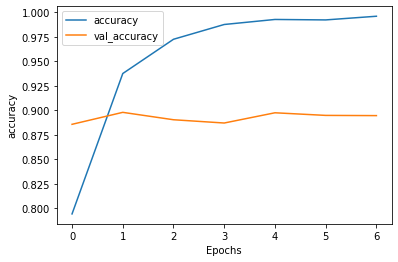

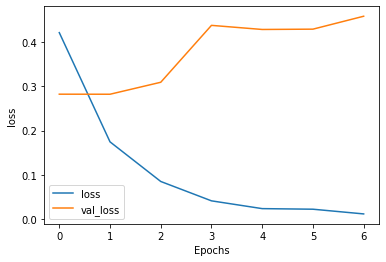

In [19]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')